In [12]:
import pandas as pd
import numpy as np

In [430]:
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import glob
%matplotlib inline
sns.set('notebook')
current_palette = sns.color_palette()

In [437]:
def load_grimm(folder):
    grimm = pd.read_csv(path.join(folder, 'DATA.TSV'), delimiter='\t',skiprows=7)
    grimm.index = [pd.to_datetime(grimm.Date[i]+' '+grimm.Time[i]) for i in range(len(grimm))]
    return grimm

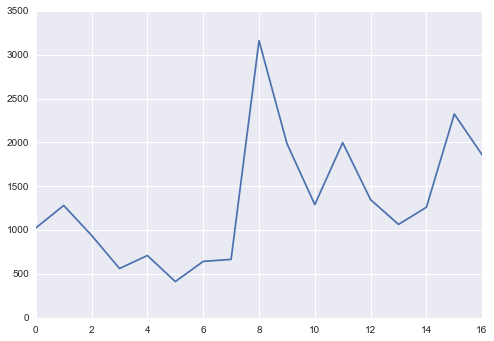

In [452]:
grimm = load_grimm('data/090915B')
plt.plot(grimm[u'2.0um'])

In [449]:
def load_specks(folder):
    specks = []
    for speck_file in glob.glob(path.join(folder, '*.csv')):
        speck = pd.read_csv(speck_file)
        speck.index = pd.to_datetime(speck['timestamp_utc_secs']+3600, unit='s')
        kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_matrices=[[1]], observation_matrices=[[1]], observation_covariance=[[1e6]], transition_covariance=[[1e3]])
        speck['filtered'] = kf.smooth(speck.raw_particles.values)[0]
        specks.append(speck)
    return specks

In [450]:
specks = load_specks('data/090915B/data')

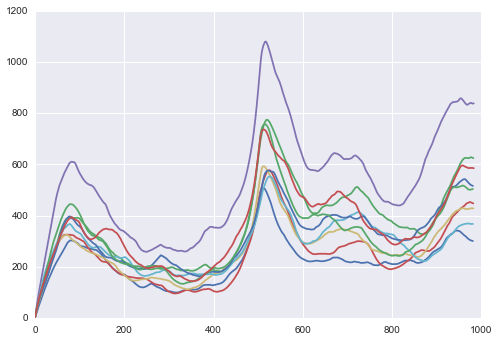

In [451]:
for speck in specks:
    plt.plot(speck.filtered)

In [455]:
def get_scale(speck, grimm):
    d = []
    scales = np.linspace(0,10,30)
    for x in scales:
        d.append(sum([(x*speck.loc[grimm.index[i], 'filtered'] - grimm[u'2.0um'][i])**2 for i in range(len(grimm)-1)]))
    return min(zip(d, scales))[1]

In [457]:
scales = [get_scale(speck, grimm) for speck in specks]

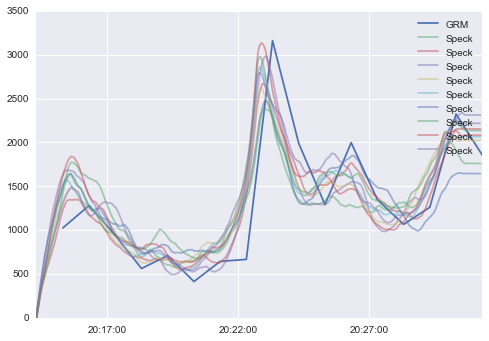

In [460]:
ax = plt.subplot(111)
ax.plot(grimm.index, grimm[u'2.0um'], label='GRM')

for scale, speck in zip(scales, specks):
    #ax.plot(specks[i].index, specks[i].particle_concentration*60, '--', c=current_palette[i+1], alpha=0.7, label='Speck')
    ax.plot(speck.index, speck.filtered*scale, alpha=0.5, label='Speck')

plt.legend()